# Ch06_2.배깅(Bagging)

## 1.기본 package 설정

In [1]:
## 1.기본
import numpy as np  # numpy 패키지 가져오기
import matplotlib.pyplot as plt # 시각화 패키지 가져오기

## 2.데이터 가져오기
import pandas as pd # csv -> dataframe으로 전환
from sklearn import datasets # python 저장 데이터 가져오기

## 3.데이터 전처리
from sklearn.preprocessing import StandardScaler # 연속변수의 표준화
from sklearn.preprocessing import LabelEncoder # 범주형 변수 수치화

# 4. 훈련/검증용 데이터 분리
from sklearn.model_selection import train_test_split 

## 5.분류모델구축 (3장.p.83~130)
from sklearn.tree import DecisionTreeClassifier # 결정 트리
# from sklearn.naive_bayes import GaussianNB # 나이브 베이즈
# from sklearn.neighbors import KNeighborsClassifier # K-최근접 이웃
# from sklearn.linear_model import Perceptron # 퍼셉트론
# from sklearn.linear_model import LogisticRegression # 로지스틱 회귀 모델
# from sklearn.svm import SVC # 서포트 벡터 머신(SVM)
# from sklearn.neural_network import MLPClassifier # 다층인공신경망

## 5_1.앙상블 모델 구축 (7장.p.252~288)
from sklearn.ensemble import VotingClassifier # 과반수 투표(Majority Voting) 
from sklearn.ensemble import BaggingClassifier # 배깅(Bagging) 
from sklearn.ensemble import AdaBoostClassifier # 부스팅(Boosting) 
from sklearn.ensemble import RandomForestClassifier # 랜덤 포레스트


## 6.모델검정
from sklearn.metrics import confusion_matrix, classification_report # 정오분류표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score # 정확도, 민감도 등
from sklearn.metrics import roc_curve, auc # ROC 곡선 그리기

## 7.최적화
from sklearn.model_selection import cross_validate # 교차타당도
from sklearn.pipeline import make_pipeline # 파이프라인 구축
from sklearn.model_selection import learning_curve, validation_curve # 학습곡선, 검증곡선
from sklearn.model_selection import GridSearchCV # 하이퍼파라미터 튜닝
from sklearn.model_selection import cross_val_score # 교차타당도 # 추가

## 2.데이터 가져오기

### 2.1 데이터프레임으로 저장
- 원본데이터(csv)를 dataframe 형태로 가져오기(pandas)

In [2]:
bank_df = pd.read_csv('UniversalBank.csv')
bank_df.head()

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,PersonalLoan,SecuritiesAccount,CDAccount,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


- 자료구조 살펴보기

In [3]:
bank_df.shape

(5000, 14)

In [4]:
# 자료구조 살펴보기
bank_df.keys()

Index(['ID', 'Age', 'Experience', 'Income', 'ZIPCode', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'PersonalLoan', 'SecuritiesAccount',
       'CDAccount', 'Online', 'CreditCard'],
      dtype='object')

### 2.2 data와 target으로 분리
- 필요한 데이터만 추출
- data: X, target: y 로 분리

In [5]:
X = bank_df.drop (['ID','ZIPCode','PersonalLoan'], axis=1)
X.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,SecuritiesAccount,CDAccount,Online,CreditCard
0,25,1,49,4,1.6,1,0,1,0,0,0
1,45,19,34,3,1.5,1,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,1


In [6]:
y = bank_df['PersonalLoan']
np.bincount(y)

array([4520,  480], dtype=int64)

## 3.데이터 전처리

### 3.1 data(X) 레이블 인코딩
- 문자형 자료를 숫자(범주형)로 인코딩 -> 범주형 변수를 가변수로 처리 : One Hot Encording
- 숫자형 자료를 표준화
- 단, 결정나무, 랜덤 포레스트, 나이브 베이즈 분류 : 원본데이터 그대로 유지

- 가변수 처리시 문자로 처리를 해야 변수명 구분이 쉬움

In [7]:
X['Education'] = X['Education'].replace ([1,2,3], ['Under','Grad','Prof'])

In [8]:
X.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,SecuritiesAccount,CDAccount,Online,CreditCard
0,25,1,49,4,1.6,Under,0,1,0,0,0
1,45,19,34,3,1.5,Under,0,1,0,0,0
2,39,15,11,1,1.0,Under,0,0,0,0,0
3,35,9,100,1,2.7,Grad,0,0,0,0,0
4,35,8,45,4,1.0,Grad,0,0,0,0,1


In [9]:
X.keys()

Index(['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education',
       'Mortgage', 'SecuritiesAccount', 'CDAccount', 'Online', 'CreditCard'],
      dtype='object')

In [10]:
X = pd.get_dummies(X[['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education', 
                      'Mortgage', 'SecuritiesAccount', 'CDAccount', 'Online', 'CreditCard']],
                   columns=['Education'],
                   drop_first = True)

In [11]:
X.head()

,Age,Experience,Income,Family,CCAvg,Mortgage,SecuritiesAccount,CDAccount,Online,CreditCard,Education_Prof,Education_Under
0,25,1,49,4,1.6,0,1,0,0,0,0,1
1,45,19,34,3,1.5,0,1,0,0,0,0,1
2,39,15,11,1,1.0,0,0,0,0,0,0,1
3,35,9,100,1,2.7,0,0,0,0,0,0,0
4,35,8,45,4,1.0,0,0,0,0,1,0,0


### 3.2 Class(target) 레이블 인코딩
- class(y)가 숫자형으로 되어 있기 때문에 변환 없음

In [12]:
y

0       0
1       0
2       0
3       0
4       0
       ..
4995    0
4996    0
4997    0
4998    0
4999    0
Name: PersonalLoan, Length: 5000, dtype: int64

## 4.훈련/검증용 데이터 분할
- test_size: 검증데이터 30%
- random_state : random seed 번호 = 1
- stratify : y(클래스)의 비율에 따라 분할

In [13]:
# \ 이후에 space 없어야 함
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, 
                         test_size=0.3, 
                         random_state=1, 
                         stratify=y)

## 5.모델구축
- 기본 및 배깅 모델 구축

In [14]:
tree = DecisionTreeClassifier(max_depth=None,
                              criterion='entropy',
                              random_state=1)

bagging = BaggingClassifier(base_estimator=tree, # 수정
                            n_estimators=500,  
                            max_samples=1.0, 
                            max_features=1.0, 
                            bootstrap=True, 
                            bootstrap_features=False, 
                            n_jobs=1, 
                            random_state=1)

clf_labels = ['Decision tree', 'Bagging']

all_clf = [tree, bagging]

## 6. 모델검정

### 6.1 AUC 검정

In [15]:
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.3f (+/- %0.3f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.944 (+/- 0.032) [Decision tree]
ROC AUC: 0.998 (+/- 0.002) [Bagging]


### 6.2 ROC 곡선 그리기


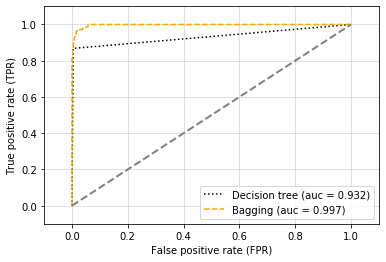

In [16]:
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls \
        in zip(all_clf, clf_labels, colors, linestyles):

    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.3f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show()

### 6.3 정오분류표로 검정

In [17]:
bagging.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='entropy',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=1,
                                                        splitter='best'),
    

In [18]:
y_pred = bagging.predict(X_test)

In [19]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],1352,4
True[1],21,123


In [20]:
print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())
print('정확도: %.3f' % accuracy_score(y_test, y_pred))
print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

잘못 분류된 샘플 개수: 25
정확도: 0.983
정밀도: 0.969
재현율: 0.854
F1: 0.908
